In [1]:
import glob
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import signal,stats
from ephysvibe.trials.spikes import firing_rate
from ephysvibe.trials import select_trials
from ephysvibe.spike_sorting import config
from ephysvibe.task import def_task,task_constants
from collections import defaultdict
from typing import Dict
import logging
from scipy import fft,signal

from sklearn.model_selection import train_test_split, GridSearchCV,KFold,cross_val_score,StratifiedKFold
from sklearn.svm import SVC,LinearSVC
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn import metrics

seed=2023

In [2]:
def get_fr_df(filepath,in_out,cgroup,e_align):
    py_f = np.load(filepath,allow_pickle=True).item(0)
    sp = py_f['sp_data']
    bhv = py_f['bhv']
    trial_idx = select_trials.select_trials_block(sp, n_block=1)
    trial_idx = select_trials.select_correct_trials(bhv, trial_idx)
    task = def_task.create_task_frame(trial_idx, bhv, task_constants.SAMPLES_COND)
    neurons = np.where(sp["clustersgroup"] == cgroup)[0]
    fr_samples = firing_rate.fr_by_sample_neuron(
            sp=sp,
            neurons=neurons,
            task=task,
            in_out=in_out,
            kernel=0,
            e_align=e_align,
            plot=False
        )
    return fr_samples

In [3]:
# load all pfc files
pfc_path = "/home/INT/losada.c/Documents/data/test/areas/pfc/*"
list = glob.glob(pfc_path)
cgroup = "good"
in_out=1
e_align=2
win_size = 100
step = 1
fix_duration = 200
sample_duration = 450
fr_samples=[]
max_n_trials = []
num_neurons = 0
for n_path, path in enumerate(list):
    print(path)
    df= get_fr_df(path,in_out,cgroup,e_align)
    rolling_df = df.loc[:,:'neuron'].iloc[:,:-1].rolling(window = win_size,axis=1,step=step,min_periods=1).mean()
    rolling_df = rolling_df.iloc[:,df['sample_on'][0]-fix_duration:df['sample_on'][0]+sample_duration]
    rolling_df.columns = np.arange(sample_duration+fix_duration)
    rolling_df = pd.concat([rolling_df,df[['neuron','sample','trial_idx']]],axis=1)
    # max number of trials that can be used 
    max_n_trials.append(rolling_df[['neuron','sample']][rolling_df['neuron']==1].groupby(['sample']).count().min()[0])
    # rename neurons
    unique_neurons = rolling_df['neuron'].unique()
    rolling_df['neuron'].replace(unique_neurons,np.arange(num_neurons,num_neurons+len(unique_neurons)),inplace=True)
    num_neurons += len(unique_neurons)
    # rename trials
    unique_trials = rolling_df['trial_idx'].unique()
    rolling_df['trial_idx'].replace(unique_trials,np.arange(len(unique_trials)),inplace=True)
    fr_samples.append(rolling_df)
all_df = pd.concat(fr_samples)

/home/INT/losada.c/Documents/data/test/areas/pfc/2022-11-22_10-59-03_Riesling_pfc_e1_r1.npy
Number of trials in block 1: 1308
Number of correct trials in block 2: 574
/home/INT/losada.c/Documents/data/test/areas/pfc/2022-12-14_10-50-49_Riesling_pfc_e1_r1.npy
Number of trials in block 1: 1753
Number of correct trials in block 2: 874
/home/INT/losada.c/Documents/data/test/areas/pfc/2022-11-30_10-42-03_Riesling_pfc_e1_r1.npy
Number of trials in block 1: 1588
Number of correct trials in block 2: 769
/home/INT/losada.c/Documents/data/test/areas/pfc/2022-11-28_10-23-27_Riesling_pfc_e1_r1.npy
Number of trials in block 1: 1536
Number of correct trials in block 2: 657
/home/INT/losada.c/Documents/data/test/areas/pfc/2022-12-16_10-30-59_Riesling_pfc_e1_r1.npy
Number of trials in block 1: 1340
Number of correct trials in block 2: 582


In [4]:
def compute_window_matrix(all_df,n_win,seed):
    y,all_samples = [], []
    for i_sample in all_df['sample'].unique():
        n_df = all_df[all_df['sample']==i_sample]
        data = n_df[[n_win,'neuron','trial_idx']]
        n_pivot = pd.pivot_table(data, values=n_win,index='trial_idx',columns='neuron').reset_index(drop=True).loc[:,0:]
        sample_df = []    
        for n in np.arange(len(n_pivot.columns)):
            sample_df.append(n_pivot.loc[~n_pivot[n].isna(),n].sample(min(max_n_trials),random_state=seed).reset_index(drop=True))
        all_samples.append(pd.concat(sample_df,axis=1))
        y.append([i_sample]*min(max_n_trials))
    return pd.concat(all_samples),np.concatenate(y)


### SVM

In [5]:
def run_svm_decoder(model,all_df,n_iterations,windows,it_seed):
    scores = np.zeros((n_iterations,windows))
    for n_it in np.arange(n_iterations):       
        for n_win in np.arange(0,windows):
            #  select trials randomly
            X,y = compute_window_matrix(all_df,n_win,it_seed[n_it])
            # split in train and test
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,shuffle=True, random_state=it_seed[n_it])
            X_train['label_encoder'] = y_train
            # Sample with replacement (only train set)
            X_train = X_train.sample(len(X_train),random_state=it_seed[n_it],replace=True)
            y_train = X_train['label_encoder']
            X_train = X_train.iloc[:,:-1]
            model.fit(X_train,y_train)
            y_predict = model.predict(X_test)
            scores[n_it, n_win] = metrics.accuracy_score(y_test,y_predict)# cross_val_score(model, X, y, cv=kf,n_jobs=-1).mean()
    return scores

In [6]:
# plot results
def plot_accuracy(scores,win_steps,neuron_max_shift,x_lim_min,x_lim_max,n_neuron):
    fig,ax = plt.subplots()
    ax.plot(((np.arange(0,len(scores[0]))*win_steps)- neuron_max_shift[n_neuron-1])/1000,scores[:13].mean(axis=0))
    ax.set_xlim(x_lim_min, x_lim_max)
    ax.vlines(
        0, 0.3, 1, color="k", linestyles="dashed"
    )# sample on
    ax.hlines(
        0.5, x_lim_min, x_lim_max, color="gray", linestyles="solid"
    )
    ax.set_title('Is neuron %d engaged in the task?'%(n_neuron))
    ax.set(xlabel="Time (s)", ylabel="SVM classifier accuracy")
    fig.tight_layout(pad=0.2, h_pad=0.2, w_pad=0.2)
    fig.legend(['Accuracy','Sample on'], fontsize=9)

In [7]:
model=  SVC(kernel='linear',C=20,decision_function_shape='ovr',gamma=0.001)

In [8]:
from multiprocessing import Pool

In [9]:
def run_svm_decoder(model,all_df,windows,it_seed,n_it):
    scores = np.zeros((windows))
    #for n_it in np.arange(n_iterations):       
    for n_win in np.arange(0,windows):
        #  select trials randomly
        X,y = compute_window_matrix(all_df,n_win,it_seed[n_it])
        # split in train and test
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,shuffle=True, random_state=it_seed[n_it])
        X_train['label_encoder'] = y_train
        # Sample with replacement (only train set)
        X_train = X_train.sample(len(X_train),random_state=it_seed[n_it],replace=True)
        y_train = X_train['label_encoder']
        X_train = X_train.iloc[:,:-1]
        model.fit(X_train,y_train)
        y_predict = model.predict(X_test)
        scores[n_win] = metrics.accuracy_score(y_test,y_predict)# cross_val_score(model, X, y, cv=kf,n_jobs=-1).mean()
    return scores

In [10]:
le = LabelEncoder()
le.fit(all_df['sample'].unique())
all_df['sample']=le.transform(all_df['sample'])
n_iterations = 100
rng = np.random.default_rng(seed=seed)
it_seed = rng.integers(low=1, high=2023, size=n_iterations, dtype=int)
windows=650
with Pool() as pool:
    async_scores = [pool.apply_async(run_svm_decoder,args=(model,all_df,windows,it_seed,n)) for n in np.arange(n_iterations)] 
    scores2 = [asc.get() for asc in async_scores]

In [96]:
le = LabelEncoder()
le.fit(all_df['sample'].unique())
all_df['sample']=le.transform(all_df['sample'])
n_iterations = 10
rng = np.random.default_rng(seed=seed)
it_seed = rng.integers(low=1, high=2023, size=n_iterations, dtype=int)
windows=650
scores = run_svm_decoder(model,all_df,n_iterations,windows,it_seed)

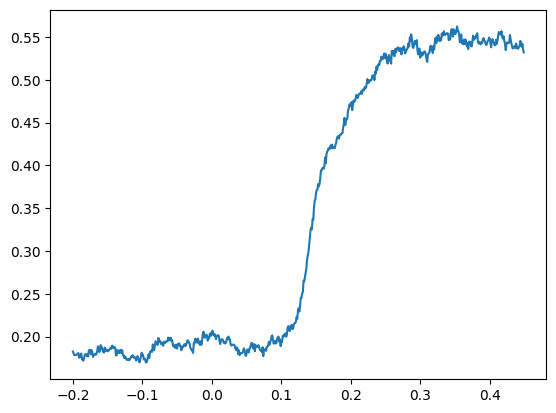

In [12]:
fig,ax = plt.subplots()
ax.plot(((np.arange(0,len(scores2[0])))-fix_duration)/1000,np.array(scores2).mean(axis=0))